**Connect Google Drive:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries:**

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)


**Load Dataset:**

In [3]:
Path="/content/drive/MyDrive/Machine Learning Track/Datasets/features.csv"
df=pd.read_csv(Path)

# display first few rows
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,5/2/2010,1643690.900,0,42.310,2.572,211.096,8.106
1,1,12/2/2010,1641957.440,1,38.510,2.548,211.242,8.106
2,1,19-02-2010,1611968.170,0,39.930,2.514,211.289,8.106
3,1,26-02-2010,1409727.590,0,46.630,2.561,211.320,8.106
4,1,5/3/2010,1554806.680,0,46.500,2.625,211.350,8.106


**Time based features:**

In [8]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Sort by date for lag features
df = df.sort_values('Date')

# Lag features
df['Temp_Lag1'] = df['Temperature'].shift(1)
df['Fuel_Price_Lag1'] = df['Fuel_Price'].shift(1)

# Rolling mean
df['Temp_MA7'] = df['Temperature'].rolling(window=7).mean()
df['Fuel_MA7'] = df['Fuel_Price'].rolling(window=7).mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 0 to 6434
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            6435 non-null   int64         
 1   Date             2565 non-null   datetime64[ns]
 2   Weekly_Sales     6435 non-null   float64       
 3   Holiday_Flag     6435 non-null   int64         
 4   Temperature      6435 non-null   float64       
 5   Fuel_Price       6435 non-null   float64       
 6   CPI              6435 non-null   float64       
 7   Unemployment     6435 non-null   float64       
 8   Year             2565 non-null   float64       
 9   Month            2565 non-null   float64       
 10  Week             2565 non-null   UInt32        
 11  Day              2565 non-null   float64       
 12  DayOfWeek        2565 non-null   float64       
 13  Temp_Lag1        6434 non-null   float64       
 14  Fuel_Price_Lag1  6434 non-null   float64     

**Data preprocessing:**

In [11]:
# Drop rows with missing values from rolling and lag features
df = df.dropna()

# Encode 'IsHoliday' to binary
df['Holiday_Flag'] = df['Holiday_Flag'].astype(int)


**Data Splitting:**

In [16]:
# Define features and target for sales forecasting
X = df.drop(columns=['Date', 'Weekly_Sales'])  # Weekly_Sales is the target column
y = df['Weekly_Sales']

# Time-aware split (last 20% for testing)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
test_dates = df['Date'].iloc[split_index:]

**Linear model training:**

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)

mae = mean_absolute_error(y_test, preds_lr)
rmse = np.sqrt(mean_squared_error(y_test, preds_lr))
print(f"Linear Regression - MAE: {mae:.3f}, RMSE: {rmse:.3f}")

Linear Regression - MAE: 442970.950, RMSE: 525371.318


**XGBoost Training:**

In [18]:

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
preds_xgb = model.predict(X_test)

mae = mean_absolute_error(y_test, preds_xgb)
rmse = np.sqrt(mean_squared_error(y_test, preds_xgb))
print(f"XGBoost - MAE: {mae:.3f}, RMSE: {rmse:.3f}")


XGBoost - MAE: 107553.545, RMSE: 161761.893


**Plot visualization:**

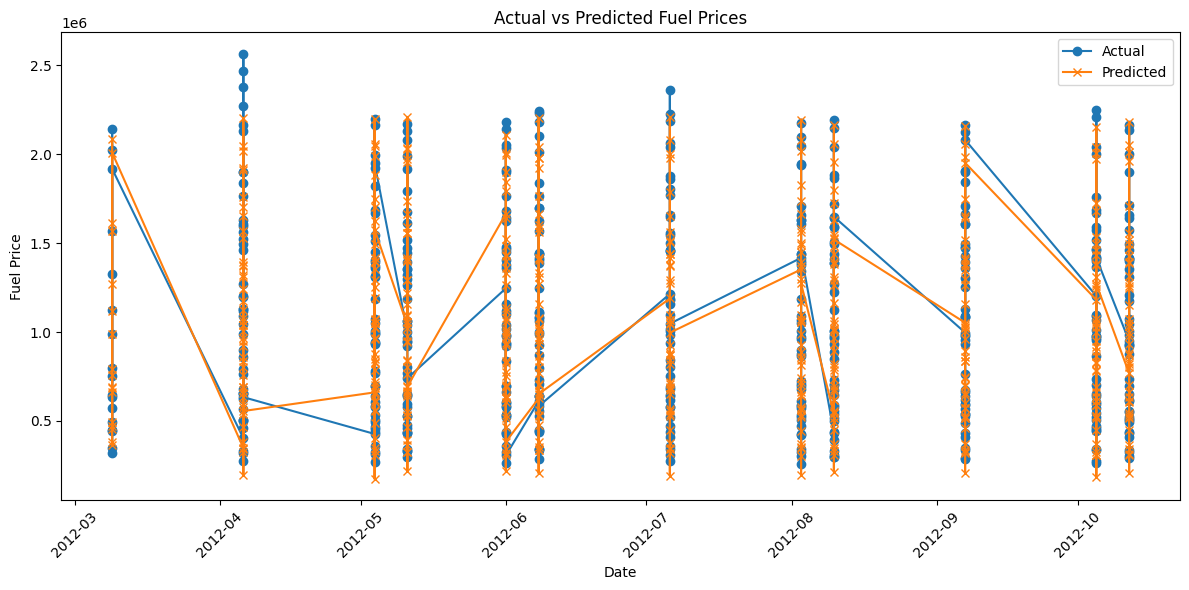

In [19]:
plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Actual', marker='o')
plt.plot(test['Date'], preds_xgb, label='Predicted', marker='x')
plt.title('Actual vs Predicted Fuel Prices')
plt.xlabel('Date')
plt.ylabel('Fuel Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


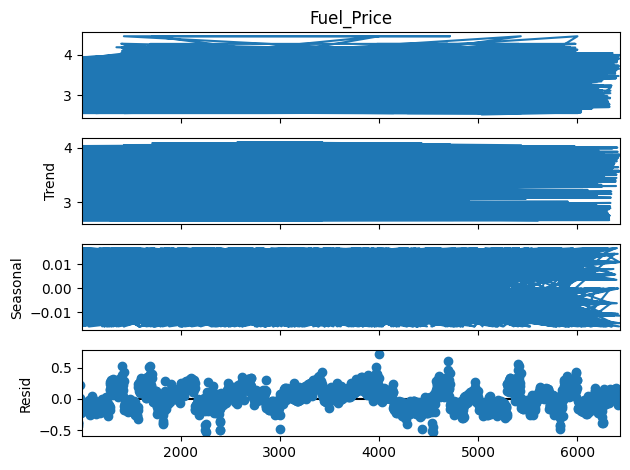

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Fuel_Price'], model='additive', period=12)
result.plot()
plt.tight_layout()
plt.show()
